In [4]:
import warnings
warnings.filterwarnings('ignore')

# Dependencies
import pytz
import datetime as dt
from datetime import datetime, timedelta
import dateparser
import gmaps
import numpy as np
import pandas as pd
import requests
import time
from pprint import pprint 
from scipy.stats import linregress
import scipy.stats as stats
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from suntime import Sun, SunTimeException
import os
import json
import urllib.request


In [6]:
data_from_arun ="/Users/Grant/Desktop/hwy_df.csv"
hwy_df = pd.read_csv(
    data_from_arun)

# Visualize

hwy_df.head()

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Traffic_Signal,Sunrise_Sunset,Civil_Twilight,Astronomical_Twilight,Direction,Accident_Date,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local
0,0,OH,3,2/8/16 5:46,2/8/16 11:00,39.865147,-84.058723,0.01,Right lane blocked due to accident on I-70 Eas...,NaN,...,False,Night,Night,Night,E,2016-02-08,2016-02-08 23:04,5:46,2016-02-08 18:04,18:04
1,3,OH,3,2/8/16 7:23,2/8/16 7:53,39.747753,-84.205582,0.01,Accident on I-75 Southbound at Exits 52 52B US...,NaN,...,False,Night,Day,Day,S,2016-02-08,2016-02-08 23:05,7:23,2016-02-08 18:05,18:05
2,11,OH,3,2/8/16 8:21,2/8/16 8:51,39.932709,-82.830910,0.01,One lane blocked due to accident on I-70 Westb...,NaN,...,False,Day,Day,Day,E,2016-02-08,2016-02-08 22:59,8:21,2016-02-08 17:59,17:59
3,49,OH,3,2/9/16 6:41,2/9/16 7:11,39.773193,-84.187454,0.01,Accident on I-75 Northbound at Exits 54A 54B O...,NaN,...,False,Night,Night,Day,S,2016-02-09,2016-02-09 23:06,6:41,2016-02-09 18:06,18:06
4,65,OH,3,2/9/16 8:23,2/9/16 8:53,39.622787,-84.229858,0.01,Accident on I-75 Southbound at I-675. Expect d...,NaN,...,False,Day,Day,Day,N,2016-02-09,2016-02-09 23:06,8:23,2016-02-09 18:06,18:06


In [7]:
hwy_df['upper_limit'] = pd.DatetimeIndex(hwy_df['Sunset_Time_Local']) + timedelta(hours=2,minutes=0)
hwy_df['upper_limit']=hwy_df['upper_limit'].dt.time

In [8]:
hwy_df['lower_limit'] = pd.DatetimeIndex(hwy_df['Sunset_Time_Local']) + timedelta(hours=-2,minutes=0)
hwy_df['lower_limit'] = hwy_df['lower_limit'].dt.time

In [9]:
#Convert sunset_time string to a datetime object
hwy_df['Sunset_Time_Local_dt']= pd.to_datetime(hwy_df['Sunset_Time_Local'],format= '%H:%M' ).dt.time

In [10]:
#Convert accident_time string to a datetime object
hwy_df['Accident_Time_dt']= pd.to_datetime(hwy_df['Accident_Time'],format= '%H:%M' ).dt.time

In [11]:
hwy_west=hwy_df[hwy_df['Direction']=='W']

In [12]:
#Check if Accident Time is within the +- 2 hour window from sunset
hwy_west['In_Window']= np.logical_and(hwy_west['lower_limit'] < hwy_west['Accident_Time_dt'], hwy_west['upper_limit'] > hwy_west['Accident_Time_dt'])


In [13]:
hwy_west=hwy_west.reset_index(drop =True)

In [14]:
type(hwy_west['Sunset_Time_Local_dt'][1])

datetime.time

In [15]:
type(hwy_west['Sunset_Time_Local'][1])

str

In [16]:
import datetime

In [17]:
time_delt=[]

datetimeFormat = '%H:%M'

for index in hwy_west.index:
    date1 = hwy_west['Sunset_Time_Local'][index]
    date2 = hwy_west['Accident_Time'][index]
    diff = datetime.datetime.strptime(date2, datetimeFormat) - datetime.datetime.strptime(date1, datetimeFormat)
    diff2=(diff.total_seconds())/60
    time_delt.append(diff2)

hwy_west['Time Delta']=time_delt

In [18]:
sunset_df=hwy_west[hwy_west['In_Window']==True]

In [19]:
sunset_df.head(2)

,index,State,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Number,...,Sunset_Time_UTC,Accident_Time,Sunset_Date_Time_Local,Sunset_Time_Local,upper_limit,lower_limit,Sunset_Time_Local_dt,Accident_Time_dt,In_Window,Time Delta
14,810,CA,3,6/21/16 20:03,6/21/16 20:48,37.766987,-121.335495,0.0,Two lanes blocked due to accident on I-205 Wes...,NaN,...,2016-06-21 03:31,20:03,2016-06-20 20:31,20:31,22:31:00,18:31:00,20:31:00,20:03:00,True,-28.0
20,931,CA,3,6/22/16 18:45,6/22/16 19:15,37.830669,-122.293343,0.0,Accident on I-80 I-580 Westbound at Exit 19A I...,NaN,...,2016-06-22 03:35,18:45,2016-06-21 20:35,20:35,22:35:00,18:35:00,20:35:00,18:45:00,True,-110.0


In [20]:
bins = [-120, -80, -40, 0, 40, 80, 120]

In [21]:
np.arange(-120,135,20)

array([-120, -100,  -80,  -60,  -40,  -20,    0,   20,   40,   60,   80,
        100,  120])

In [22]:
group_names=['120-80min before Sunset', '80-40min before Sunset', '40-0min before Sunset', \
            '0-40min after Sunset', '40-80min after Sunset', '80-120min after Sunset']

In [23]:
sunset_df['Time_From_Sunset_Bin']=pd.cut(sunset_df["Time Delta"], bins, labels=group_names)


In [44]:
sunset_df['Time_From_Sunset_Bin'].value_counts()

120-100min before Sunset    830
100-80min before Sunset     816
80-60min before Sunset      806
60-40min before Sunset      803
40-20min before Sunset      737
20-0min before Sunset       676
40-60min after Sunset       672
20-40min after Sunset       669
0-20min after Sunset        644
60-80min after Sunset       566
80-100min after Sunset      527
100-120min after Sunset     478
Name: Time_From_Sunset_Bin, dtype: int64

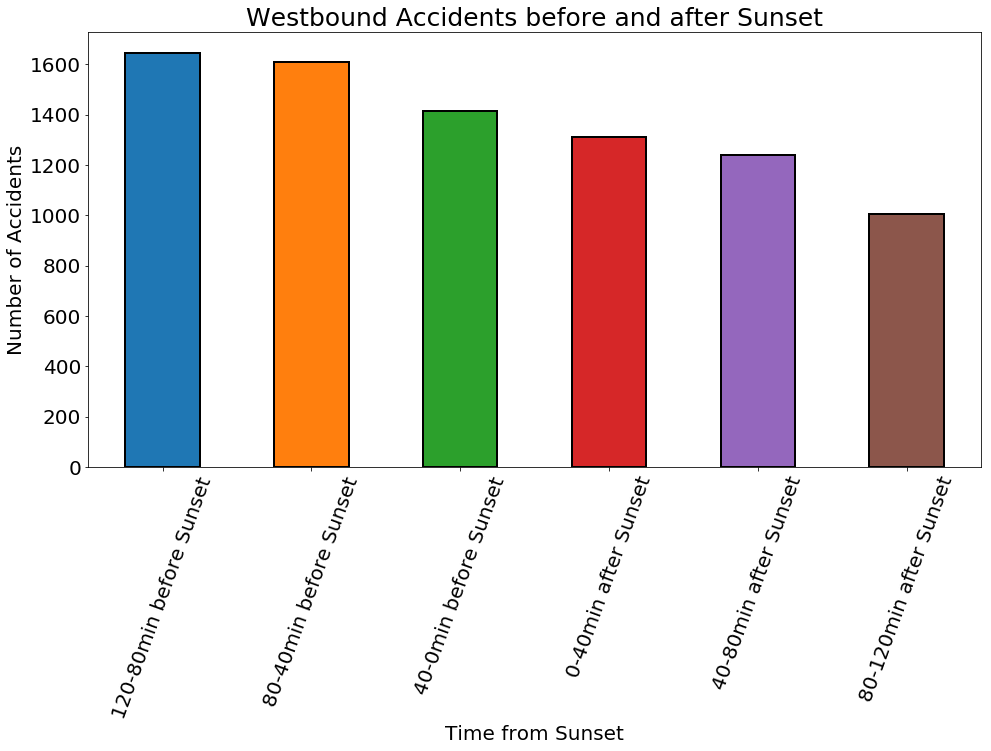

In [24]:
fig, ax = plt.subplots(figsize=(16,8))
sunset_df['Time_From_Sunset_Bin'].value_counts().plot.bar(width=0.5,edgecolor='k',align='center',linewidth=2)
plt.xlabel('Time from Sunset',fontsize=20)
plt.ylabel('Number of Accidents',fontsize=20)
ax.tick_params(labelsize=20)
plt.title('Westbound Accidents before and after Sunset',fontsize=25)
plt.xticks(rotation=70)

plt.show()